In [5]:
%run shelter_analysis.py


In [ ]:
"""Petfinder API to pull listings for adoptable pets with pagination and retry logic."""

TOKEN_URL = "https://api.petfinder.com/v2/oauth2/token"

#  Step 1: Authenticate and obtain API access token
# Request an access token using client credentials
auth_data = {
    "grant_type": "client_credentials",
    "client_id": CLIENT_ID,  # Replace with your actual Client ID
    "client_secret": CLIENT_SECRET  # Replace with your actual Client Secret
}

response = requests.post(TOKEN_URL, data=auth_data)  # Send authentication request
access_token = response.json().get("access_token")  # Extract access token

#  Check if authentication was successful
if not access_token:
    print(f" Failed to obtain access token: {response.json()}")  # Print error if authentication fails
    exit()  # Stop execution if no access token is received

#  Step 2: Define headers for authentication
# The access token is included in the headers for authentication in API requests
headers = {"Authorization": f"Bearer {access_token}"}

#  Step 3: Fetch adoptable pets using pagination with retry logic
PET_URL = "https://api.petfinder.com/v2/animals"  # URL to fetch adoptable pets
all_pets = []  # Store all retrieved pet data

page = 1  # Start pagination from page 1
while True:  # Loop until no more pets are available
    params = {"type": "dog", "location": "75001", "limit": 100, "page": page}  # Set query parameters
    success = False  # Track if request succeeds
    attempts = 0  # Track number of retry attempts

    #  Retry mechanism: Attempt the request up to 3 times
    while not success and attempts < 3:
        response = requests.get(PET_URL, params=params, headers=headers)  # Send GET request
        if response.status_code == 200:  #  Successful response
            pet_data = response.json()["animals"]  # Extract pet data
            success = True  # Mark request as successful
        else:
            #  Handle failed requests and retry
            print(f" Failed to fetch pets on page {page}: {response.status_code} - attempt {attempts+1}")
            attempts += 1
            time.sleep(5)  # Wait 5 seconds before retrying

    #  Stop pagination if the request failed after retries
    if not success:
        print(f" Giving up on page {page}.")
        break

    #  Stop fetching if no more pets are available
    if not pet_data:
        break

    all_pets.extend(pet_data)  # Add retrieved pets to the list
    page += 1  # Move to next page

#  Convert all retrieved pet data into a Pandas DataFrame
df_pets = pd.json_normalize(all_pets)

#  Step 4: Fetch shelter details dynamically
# Extract unique shelter IDs from the pet dataset
shelter_ids = df_pets["organization_id"].dropna().unique()
df_shelters = pd.DataFrame()  # Initialize an empty DataFrame to store shelter details

#  Fetch shelter details for each shelter ID
for shelter_id in shelter_ids:
    ORG_URL = f"https://api.petfinder.com/v2/organizations/{shelter_id}"  # API URL for shelter details
    response = requests.get(ORG_URL, headers=headers)  # Send GET request

    if response.status_code == 200:  # ✅ Successful response
        shelter_data = response.json()["organization"]  # Extract shelter data
        df_temp = pd.json_normalize(shelter_data)  # Convert to DataFrame format
        df_shelters = pd.concat([df_shelters, df_temp], ignore_index=True)  # Append data to the final DataFrame

# 🔗 Merge Pet & Shelter DataFrames

# ✅ Rename columns for consistency
df_pets = df_pets.rename(columns={"organization_id": "Shelter ID"})
df_shelters = df_shelters.rename(columns={"id": "Shelter ID"})

# 🔗 Merge the pet dataset with the shelter dataset
df_combined = df_pets.merge(df_shelters, on="Shelter ID", how="left")  # Left join to ensure all pets remain

# 💾 Step 5: Save DataFrames to Excel and CSV for analysis

df_pets.to_csv("adoptable_pets.csv", index=False)  # Save pet data as CSV
df_shelters.to_csv("shelter_details.csv", index=False)  # Save shelter data as CSV
df_combined.to_csv("adoptable_pets_shelters.csv", index=False)  # Save combined dataset as CSV
df_combined.to_excel("adoptable_pets_shelters.xlsx", index=False, sheet_name="Adoption Data")  # Save to Excel format

# ✅ Final confirmation message
print("✅ Data successfully saved! 🎉")
print("📂 CSV files: 'adoptable_pets.csv', 'shelter_details.csv', 'adoptable_pets_shelters.csv'")
print("📂 Excel file: 'adoptable_pets_shelters.xlsx'")
print(df_combined.head())  # Display first few rows of the combined dataset

✅ Data successfully saved! 🎉
📂 CSV files: 'adoptable_pets.csv', 'shelter_details.csv', 'adoptable_pets_shelters.csv'
📂 Excel file: 'adoptable_pets_shelters.xlsx'
         id Shelter ID                                              url_x  \
0  76577519     TX2833  https://www.petfinder.com/dog/boo-76577519/tx/...   
1  76577474     TX2833  https://www.petfinder.com/dog/jill-76577474/tx...   
2  76577415     TX2833  https://www.petfinder.com/dog/jack-ii-76577415...   
3  76577298     TX2512  https://www.petfinder.com/dog/ozzy-76577298/tx...   
4  76577355      TX150  https://www.petfinder.com/dog/cloud-76577355/t...   

  type species    age  gender    size  coat                          tags  \
0  Dog     Dog  Young  Female  Medium  None           [Friendly, Playful]   
1  Dog     Dog   Baby  Female  Medium  None               [Quiet, Gentle]   
2  Dog     Dog   Baby    Male  Medium  None  [Quiet, Couch, Affectionate]   
3  Dog     Dog  Adult    Male   Large  Long          [Independent, 

In [3]:
#https://data.longbeach.gov/explore/dataset/animal-shelter-intakes-and-outcomes/information/?disjunctive.animal_type&disjunctive.primary_color&disjunctive.sex&disjunctive.intake_cond&disjunctive.intake_type&disjunctive.reason&disjunctive.outcome_type&disjunctive.outcome_subtype&disjunctive.intake_is_dead&disjunctive.outcome_is_dead&q.daterangeslider=intake_date:%5B2024-06+TO+2025-05%5D&dataChart=eyJxdWVyaWVzIjpbeyJjaGFydHMiOlt7ImFsaWduTW9udGgiOnRydWUsInR5cGUiOiJjb2x1bW4iLCJmdW5jIjoiQ09VTlQiLCJ5QXhpcyI6ImFnZSIsInNjaWVudGlmaWNEaXNwbGF5Ijp0cnVlLCJjb2xvciI6InJhbmdlLWN1c3RvbSIsInBvc2l0aW9uIjoiY2VudGVyIn1dLCJ4QXhpcyI6ImludGFrZV9kYXRlIiwibWF4cG9pbnRzIjpudWxsLCJ0aW1lc2NhbGUiOiJtb250aCIsInNvcnQiOiIiLCJzZXJpZXNCcmVha2Rvd25UaW1lc2NhbGUiOiIiLCJzZXJpZXNCcmVha2Rvd24iOiJpbnRha2VfaXNfZGVhZCIsInN0YWNrZWQiOiJub3JtYWwiLCJjb25maWciOnsiZGF0YXNldCI6ImFuaW1hbC1zaGVsdGVyLWludGFrZXMtYW5kLW91dGNvbWVzIiwib3B0aW9ucyI6eyJkaXNqdW5jdGl2ZS5hbmltYWxfdHlwZSI6dHJ1ZSwiZGlzanVuY3RpdmUucHJpbWFyeV9jb2xvciI6dHJ1ZSwiZGlzanVuY3RpdmUuc2V4Ijp0cnVlLCJkaXNqdW5jdGl2ZS5pbnRha2VfY29uZCI6dHJ1ZSwiZGlzanVuY3RpdmUuaW50YWtlX3R5cGUiOnRydWUsImRpc2p1bmN0aXZlLnJlYXNvbiI6dHJ1ZSwiZGlzanVuY3RpdmUub3V0Y29tZV90eXBlIjp0cnVlLCJkaXNqdW5jdGl2ZS5vdXRjb21lX3N1YnR5cGUiOnRydWUsImRpc2p1bmN0aXZlLmludGFrZV9pc19kZWFkIjp0cnVlLCJkaXNqdW5jdGl2ZS5vdXRjb21lX2lzX2RlYWQiOnRydWUsInEuZGF0ZXJhbmdlc2xpZGVyIjoiaW50YWtlX2RhdGU6WzIwMjQtMDYgVE8gMjAyNS0wNV0ifX19XSwiZGlzcGxheUxlZ2VuZCI6dHJ1ZSwiYWxpZ25Nb250aCI6dHJ1ZSwidGltZXNjYWxlIjoiIn0%3D&location=6,37.42997,-109.817&basemap=jawg.streets
#animal-shelter-intakes-and-outcomes.xlsx - DATASET
#longbeach_ full & limited - API
# Define API URL (replace {dataset_id} with the actual dataset ID)
dataset_id = "animal-shelter-intakes-and-outcomes"
url = f"https://data.longbeach.gov/api/explore/v2.1/catalog/datasets/animal-shelter-intakes-and-outcomes/records"
#/api/explore/v2.1/catalog/datasets/animal-shelter-intakes-and-outcomes/records?limit=20
# Make the request
response = requests.get(url)  # Send a GET request to the specified URL and store the response
# Check response status
if response.status_code == 200:  # If the request was successful (HTTP status code 200)
    data = response.json()  # Convert the response content to JSON format
    print(data)  # Display the raw JSON data
else:  # If the request failed
    print(f"Error {response.status_code}: {response.text}")  # Print the error code and message

{'total_count': 32173, 'results': [{'animal_id': 'A721918', 'animal_name': None, 'animal_type': 'WILD', 'primary_color': 'GRAY', 'secondary_color': 'BLACK', 'sex': 'Unknown', 'dob': None, 'intake_date': '2024-05-30', 'intake_cond': 'INJURED  MODERATE', 'intake_type': 'WILDLIFE', 'intake_subtype': 'FIELD', 'reason': None, 'outcome_date': '2024-05-30', 'crossing': ',.5000 AIRPORT PLAZA DR, LONG BEACH, CA 90815', 'jurisdiction': 'LONG BEACH', 'outcome_type': 'TRANSFER', 'outcome_subtype': 'LBAH', 'latitude': 33.8071004, 'longitude': -118.1345647, 'intake_is_dead': 'Alive on Intake', 'outcome_is_dead': 'FALSE', 'was_outcome_alive': 1, 'geopoint': {'lon': -118.1345647, 'lat': 33.8071004}}, {'animal_id': 'A700840', 'animal_name': '*PIPPY', 'animal_type': 'CAT', 'primary_color': 'BLACK', 'secondary_color': 'WHITE', 'sex': 'Male', 'dob': '2023-06-01', 'intake_date': '2023-06-14', 'intake_cond': 'UNDER AGE/WEIGHT', 'intake_type': 'STRAY', 'intake_subtype': 'OTC', 'reason': None, 'outcome_date':

In [5]:
# Define API URL
dataset_id = "animal-shelter-intakes-and-outcomes"  # Specify the dataset ID
base_url = f"https://data.longbeach.gov/api/explore/v2.1/catalog/datasets/{dataset_id}/records"  # Construct API endpoint

# Initialize empty list to store results
all_records = []  # List to store retrieved records
limit = 100  # Number of records to fetch per request
offset = 0  # Start fetching from the first record
max_records = 10000  # API restriction on maximum records

# Loop to fetch data in batches until reaching the max_records limit
while offset < max_records:
    params = {"limit": limit, "offset": offset}  # Set request parameters for pagination
    response = requests.get(base_url, params=params)  # Send GET request to API

    if response.status_code == 200:  # Check if request was successful
        data = response.json()  # Parse response data as JSON
        
        # Check if results exist in the response
        if 'results' in data and len(data['results']) > 0:
            all_records.extend(data['results'])  # Add batch of records to the dataset
            offset += limit  # Update offset to fetch next batch
        else:
            break  # Exit loop if no more records are available
    else:
        print(f"Error {response.status_code}: {response.text}")  # Print error message if request fails
        break  # Exit loop on failure

# Save data if records were successfully retrieved
if all_records:
    df = pd.DataFrame(all_records)  # Convert records list into a pandas DataFrame
    df.to_csv("longbeach_limited_dataset.csv", index=False, encoding="utf-8")  # Save data to a CSV file
    print("Data saved to longbeach_limited_dataset.csv")  # Print success message
else:
    print("No records found.")  # Print message if no data was retrieved

Data saved to longbeach_limited_dataset.csv


In [11]:
df = pd.read_csv ("longbeach_limited_dataset.csv")
print(df.shape)
print(df.columns)
df.head()

(10000, 23)
Index(['animal_id', 'animal_name', 'animal_type', 'primary_color',
       'secondary_color', 'sex', 'dob', 'intake_date', 'intake_cond',
       'intake_type', 'intake_subtype', 'reason', 'outcome_date', 'crossing',
       'jurisdiction', 'outcome_type', 'outcome_subtype', 'latitude',
       'longitude', 'intake_is_dead', 'outcome_is_dead', 'was_outcome_alive',
       'geopoint'],
      dtype='object')


,animal_id,animal_name,animal_type,primary_color,secondary_color,sex,dob,intake_date,intake_cond,intake_type,...,crossing,jurisdiction,outcome_type,outcome_subtype,latitude,longitude,intake_is_dead,outcome_is_dead,was_outcome_alive,geopoint
0,A721918,NaN,WILD,GRAY,BLACK,Unknown,NaN,2024-05-30,INJURED MODERATE,WILDLIFE,...,",.5000 AIRPORT PLAZA DR, LONG BEACH, CA 90815",LONG BEACH,TRANSFER,LBAH,33.807100,-118.134565,Alive on Intake,False,1,"{'lon': -118.1345647, 'lat': 33.8071004}"
1,A700840,*PIPPY,CAT,BLACK,WHITE,Male,2023-06-01,2023-06-14,UNDER AGE/WEIGHT,STRAY,...,+4900 BLK GRISHAM AVE LONG BEACH 90805,LONG BEACH,RESCUE,LITTLEPAWS,33.844909,-118.194040,Alive on Intake,False,1,"{'lon': -118.1940398, 'lat': 33.8449089}"
2,A646450,NaN,BIRD,WHITE,GRAY,Unknown,2019-07-31,2020-07-31,INJURED MODERATE,WILDLIFE,...,"0 7TH PL, LONG BEACH, CA 90802",LONG BEACH,RESCUE,IBR,33.765488,-118.176030,Alive on Intake,False,1,"{'lon': -118.1760301, 'lat': 33.7654884}"
3,A707681,NaN,CAT,GRAY TABBY,NaN,Unknown,2023-03-27,2023-09-27,INJURED MODERATE,STRAY,...,0 BLK E LOUISE,LONG BEACH,EUTHANASIA,INJ SEVERE,33.855084,-118.196971,Alive on Intake,True,0,"{'lon': -118.1969706, 'lat': 33.8550845}"
4,A593145,NaN,CAT,GRAY,NaN,Female,2017-05-08,2017-07-08,FERAL,STRAY,...,"0 BLK E MARKET ST, LONG BEACH, CA 90805",LONG BEACH,RESCUE,CATPAWS,33.854284,-118.196492,Alive on Intake,False,1,"{'lon': -118.1964921, 'lat': 33.8542837}"


In [6]:
df1 = pd.read_excel ("animal-shelter-intakes-and-outcomes.xlsx")
print(df1.shape)
print(df1.columns)
df1.head()

(31735, 23)
Index(['Animal ID', 'Animal Name', 'Animal Type', 'Primary Color',
       'Secondary Color', 'Sex', 'DOB', 'Intake Date', 'Intake Condition',
       'Intake Type', 'Intake Subtype', 'Reason for Intake', 'Outcome Date',
       'Crossing', 'Jurisdiction', 'Outcome Type', 'Outcome Subtype',
       'latitude', 'longitude', 'intake_is_dead', 'outcome_is_dead',
       'was_outcome_alive', 'geopoint'],
      dtype='object')


,Animal ID,Animal Name,Animal Type,Primary Color,Secondary Color,Sex,DOB,Intake Date,Intake Condition,Intake Type,...,Crossing,Jurisdiction,Outcome Type,Outcome Subtype,latitude,longitude,intake_is_dead,outcome_is_dead,was_outcome_alive,geopoint
0,A693708,*CHARLIEN,DOG,WHITE,NaN,Female,2013-02-21,2023-02-20,ILL MILD,STRAY,...,"[2600 BLK LONG BEACH BLVD, LONG BEACH CA, 90806",LONG BEACH,EUTHANASIA,ILL SEVERE,33.804794,-118.188926,Alive on Intake,True,0,"33.8047935, -118.1889261"
1,A638068,NaN,BIRD,GREEN,RED,Unknown,NaN,2020-01-01,INJURED SEVERE,WILDLIFE,...,"0 BLK GRAND AVE, LONG BEACH, CA 90803",LONG BEACH,EUTHANASIA,INJ SEVERE,33.760478,-118.148091,Alive on Intake,True,0,"33.7604783, -118.1480912"
2,A618968,*MORGAN,CAT,BLACK,WHITE,Female,2014-12-18,2018-12-18,INJURED SEVERE,STRAY,...,"0 BLK W ZANE ST, LONG BEACH, CA 90805",LONG BEACH,RESCUE,LITTLELION,33.849501,-118.194905,Alive on Intake,False,1,"33.8495009, -118.1949053"
3,A730385,*BRANDON,RABBIT,BLACK,WHITE,Neutered,2023-04-19,2024-10-18,NORMAL,STRAY,...,00 AQUARIUM WAY LONG BEACH CA 90802,LONG BEACH,ADOPTION,WEB,33.763986,-118.194410,Alive on Intake,False,1,"33.7639859, -118.1944096"
4,A595225,NaN,DOG,BLUE MERLE,WHITE,Male,2015-08-12,2017-08-12,NORMAL,STRAY,...,"00 BLK 1ST ST, SEAL BEACH,, CA 90740",SEAL BEACH,TRANSFER,SBACC,33.743036,-118.113624,Alive on Intake,False,1,"33.7430361, -118.1136241"


In [8]:
# Filter the dataset to include only dogs
df_dogs = df1[df1["Animal Type"].str.upper() == "DOG"].copy()

# Print the column names of the filtered DataFrame
print(f'Columns of the dataframe : \n{df_dogs.columns}')

# Calculate the number of missing values in each column
missing_value = df_dogs.isnull().sum()  

# Print the missing value count for each column
print(f'\nMissing values : \n {missing_value}')

# Print information about the DataFrame, including column types and memory usage
print(f'\nInformation about column types:\n{df_dogs.info()}')

Columns of the dataframe : 
Index(['Animal ID', 'Animal Name', 'Animal Type', 'Primary Color',
       'Secondary Color', 'Sex', 'DOB', 'Intake Date', 'Intake Condition',
       'Intake Type', 'Intake Subtype', 'Reason for Intake', 'Outcome Date',
       'Crossing', 'Jurisdiction', 'Outcome Type', 'Outcome Subtype',
       'latitude', 'longitude', 'intake_is_dead', 'outcome_is_dead',
       'was_outcome_alive', 'geopoint'],
      dtype='object')

Missing values : 
 Animal ID               0
Animal Name          1624
Animal Type             0
Primary Color           0
Secondary Color      4116
Sex                     0
DOB                   172
Intake Date             0
Intake Condition        0
Intake Type             0
Intake Subtype        259
Reason for Intake    9152
Outcome Date           77
Crossing                0
Jurisdiction            0
Outcome Type           82
Outcome Subtype      1293
latitude                0
longitude               0
intake_is_dead          0
outcome_is_

In [9]:
# List of columns to standardize formatting
columns_to_standardize = ["Animal Type", "Intake Type", "Sex", "Primary Color", "Intake Subtype", "Reason for Intake"]

# Apply uppercase and strip whitespace to each specified column
for col in columns_to_standardize:
    df_dogs[col] = df_dogs[col].str.upper().str.strip()

# Handle missing values by filling empty entries
missing_value_mapping = {
    "Animal Name": "Unknown",
    "Secondary Color": "Not Specified",
    "Reason for Intake": "Unknown",
    "Intake Subtype": "UNKNOWN"
}

for col, value in missing_value_mapping.items():
    df_dogs[col] = df_dogs[col].fillna(value)

# Fix inconsistent values using mapping dictionaries
fix_subtype_mapping = {
    "ABAN FIELD": "ABANDONED FIELD",
    "ABAN SHLTR": "ABANDONED SHELTER",
    "INVESTIGAT": "INVESTIGATION",
    "BORN@SHELT": "BORN AT SHELTER",
    "SPCALA": "SPCALA RESCUE",
    "PUB SAFETY": "PUBLIC SAFETY"
}

df_dogs["Intake Subtype"] = df_dogs["Intake Subtype"].replace(fix_subtype_mapping)

# Group similar categories
category_mapping = {
    "FIELD": "FIELD RESCUE",
    "POLICE": "LAW ENFORCEMENT",
    "HOSPITAL": "MEDICAL",
    "VICIOUS": "AGGRESSIVE ANIMAL",
    "OWNER DIED": "OWNER ISSUE",
    "EVICTION": "OWNER ISSUE",
    "CRUELTY": "NEGLECT/ABUSE",
    "RESCUE": "GENERAL RESCUE",
    "AT SHELTER": "SHELTER ENTRY"
}

df_dogs["Intake Category"] = df_dogs["Intake Subtype"].replace(category_mapping)

# Fix spelling errors and common abbreviations
fix_reason_mapping = {
    "DISOBEDIEN": "DISOBEDIENCE",
    "NOFRIENDLY": "NOT FRIENDLY",
    "POOR HELTH": "POOR HEALTH",
    "FORCLOSURE": "FORECLOSURE",
    "SEP ANXITY": "SEPARATION ANXIETY",
    "RESPONSIBL": "RESPONSIBILITY ISSUE",
    "DESTRUC IN": "DESTRUCTIVE INDOORS",
    "DESTRUC OT": "DESTRUCTIVE OUTDOORS",
    "EUTH ILL": "EUTHANASIA - ILLNESS",
    "EUTH OLD": "EUTHANASIA - OLD AGE",
    "EUTH OTHER": "EUTHANASIA - OTHER"
}

df_dogs["Reason for Intake"] = df_dogs["Reason for Intake"].replace(fix_reason_mapping)

# Map intake types to standardized categories
intake_mapping = {
    "STRAY": "FOUND ANIMAL",
    "OWNER SURRENDER": "OWNER RELINQUISHED",
    "WELFARE SEIZED": "LEGAL SEIZURE",
    "SAFE KEEP": "TEMPORARY HOLD",
    "CONFISCATE": "LEGAL SEIZURE",
    "RETURN": "RETURNED TO SHELTER",
    "QUARANTINE": "MEDICAL HOLD",
    "RETURNED ADOPTION": "RETURNED TO SHELTER",
    "WILDLIFE": "WILD ANIMAL",
    "EUTHANASIA REQUIRED": "MEDICAL HOLD"
}

df_dogs["Intake Category"] = df_dogs["Intake Type"].replace(intake_mapping)

df_dogs["Intake Category"] = df_dogs["Intake Type"].replace(intake_mapping).fillna(df_dogs["Intake Type"])

# Apply categorization for "Reason for Intake"
reason_category_mapping = {
    "BITES": "AGGRESSIVE BEHAVIOR",
    "AGG ANIMAL": "AGGRESSIVE BEHAVIOR",
    "AGG PEOPLE": "AGGRESSIVE BEHAVIOR",
    "WATCHDOG": "BEHAVIORAL ISSUE",
    "JUMPS UP": "BEHAVIORAL ISSUE",
    "VOCAL": "BEHAVIORAL ISSUE",
    "SEP ANXITY": "BEHAVIORAL ISSUE",
    "COMPET ATT": "BEHAVIORAL ISSUE",
    "SHEDS": "GROOMING ISSUE",
    "KILLS ANIM": "AGGRESSIVE BEHAVIOR",
    "NO TIME": "OWNER ISSUE",
    "COST": "OWNER ISSUE",
    "MOVE": "OWNER ISSUE",
    "LANDLORD": "OWNER ISSUE",
    "FORECLOSURE": "OWNER ISSUE",
    "DIVORCE": "OWNER ISSUE",
    "OWNER DIED": "OWNER ISSUE",
    "CHILD PROB": "HOUSEHOLD ISSUE",
    "NEW BABY": "HOUSEHOLD ISSUE",
    "TOO BIG": "SIZE ISSUE",
    "TOO MANY": "MULTIPLE PETS ISSUE",
    "WANTS OUT": "ESCAPE ISSUE",
    "ESCAPES": "ESCAPE ISSUE",
    "UNKNOWN": "UNKNOWN REASON",
    "ABANDON": "ABANDONMENT",
    "FOUND ANIM": "STRAY",
    "INJURED": "MEDICAL ISSUE",
    "ILL": "MEDICAL ISSUE",
    "EUTHANASIA - ILLNESS": "MEDICAL ISSUE",
    "EUTHANASIA - OLD AGE": "MEDICAL ISSUE",
    "EUTHANASIA - OTHER": "MEDICAL ISSUE",
    "DOA": "MEDICAL ISSUE",
    "ATTENTION": "BEHAVIORAL ISSUE"
}

df_dogs["Intake Category"] = df_dogs["Reason for Intake"].replace(reason_category_mapping)

# Convert intake and outcome dates to datetime format
df_dogs["Intake Date"] = pd.to_datetime(df_dogs["Intake Date"])
df_dogs["Outcome Date"] = pd.to_datetime(df_dogs["Outcome Date"])

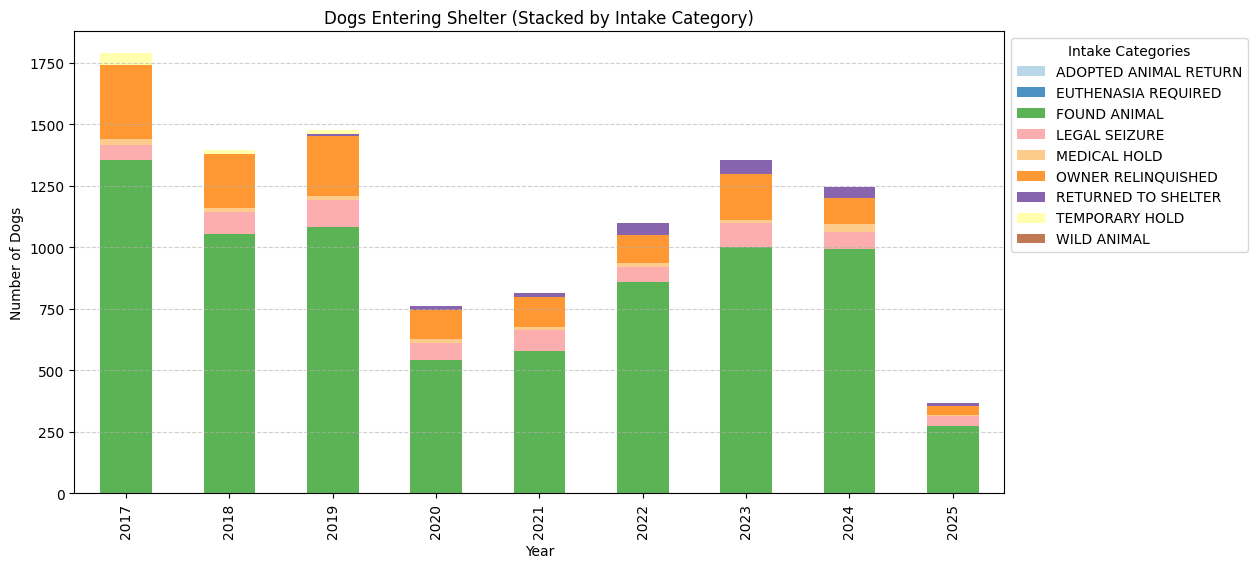

In [10]:

# Ensure Intake Category exists
df_dogs["Intake Category"] = df_dogs["Intake Type"].replace(intake_mapping).fillna(df_dogs["Intake Type"])

# Group dogs entering per year by intake category
dogs_entered_by_category = df_dogs.groupby([df_dogs["Intake Date"].dt.year, df_dogs["Intake Category"]]).size().unstack(fill_value=0)

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
# Stacked bar chart for dogs entering each year by intake category
dogs_entered_by_category.plot(kind='bar', stacked=True, ax=ax, colormap='Paired', alpha=0.8)

# Labels and title
ax.set_xlabel("Year")
ax.set_ylabel("Number of Dogs")
ax.set_title("Dogs Entering Shelter (Stacked by Intake Category)")
ax.grid(axis="y", linestyle="--", alpha=0.6)

# Add legend for intake categories
ax.legend(title="Intake Categories", loc="upper left", bbox_to_anchor=(1, 1))
plt.show()


In [11]:
#  Extract the year
df_dogs["Year"] = df_dogs["Intake Date"].dt.year

#  Count number of dogs entering per year
dogs_entered_per_year = df_dogs.groupby("Year").size()

#  Count total outcomes per year (sum of all exits)
outcomes_per_year = df_dogs.groupby(df_dogs["Outcome Date"].dt.year).size()

#  Determine number of dogs remaining at the end of each year
dogs_remaining_by_year = {}

years = range(df_dogs["Year"].min(), df_dogs["Year"].max() + 1)

for year in years:
    entered = df_dogs[df_dogs["Year"] <= year]  # Dogs that entered up to this year
    exited = entered[entered["Outcome Date"].dt.year <= year]  # Dogs that exited up to this year
    remaining = len(entered) - len(exited)  # Remaining dogs at end of the year
    dogs_remaining_by_year[year] = remaining

#  Convert results to DataFrame
remaining_df = pd.DataFrame(list(dogs_remaining_by_year.items()), columns=["Year", "Remaining Dogs"])

#  Merge data into a single DataFrame for stacked visualization
data_stacked = pd.DataFrame({
    "Entries": dogs_entered_per_year,
    "Outcomes": outcomes_per_year,
    "Remaining": remaining_df.set_index("Year")["Remaining Dogs"]
}).fillna(0)  # Fill missing years with zeros

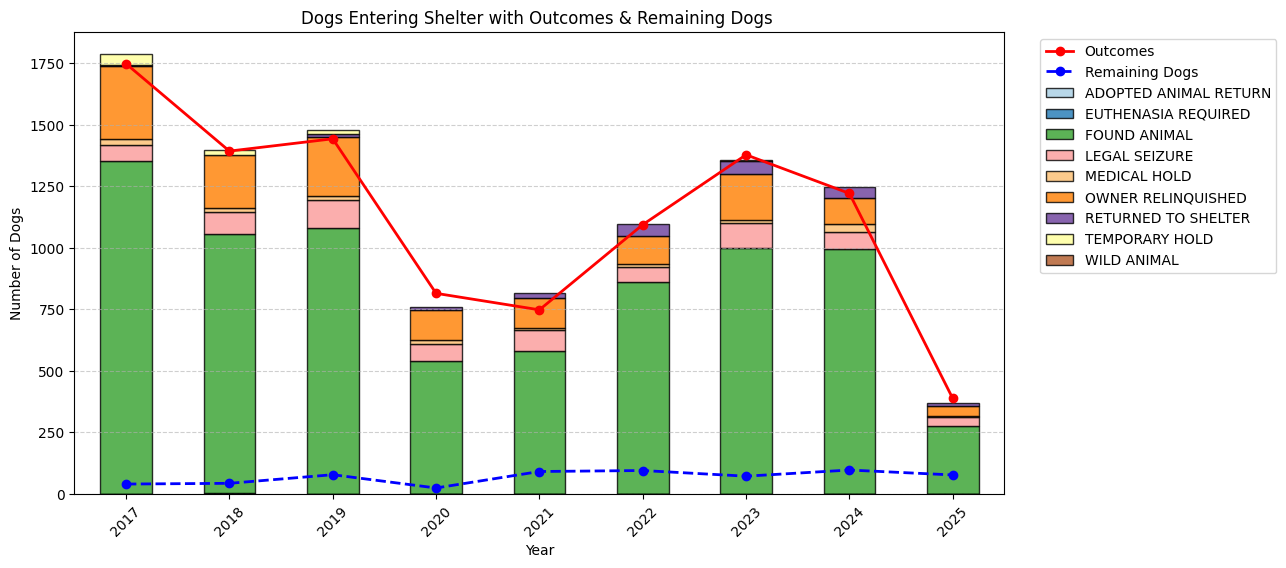

In [12]:

#  Rename "Stray" to "Found Animals"
dogs_entered_by_category.rename(columns={"Stray": "Found Animals"}, inplace=True)

#  Create figure
fig, ax1 = plt.subplots(figsize=(12, 6))

#  Stacked bar chart for entries by intake category
dogs_entered_by_category.plot(kind="bar", stacked=True, ax=ax1, colormap="Paired", edgecolor="black", alpha=0.8)

#  Explicit x-values for line plots
x_values = range(len(dogs_entered_by_category.index))

#  Line plot for Outcomes
ax1.plot(x_values, outcomes_per_year.values, marker="o", linestyle="-", color="red", linewidth=2, label="Outcomes")

#  Line plot for Remaining Dogs
ax1.plot(x_values, remaining_df["Remaining Dogs"].values, marker="o", linestyle="--", color="blue", linewidth=2, label="Remaining Dogs")

#  Adjust x-axis labels to show years correctly
ax1.set_xticks(x_values)
ax1.set_xticklabels(dogs_entered_by_category.index.astype(int), rotation=45)

#  Labels and title
ax1.set_xlabel("Year")
ax1.set_ylabel("Number of Dogs")
ax1.set_title("Dogs Entering Shelter with Outcomes & Remaining Dogs ")
ax1.grid(axis="y", linestyle="--", alpha=0.6)

#  **Move Intake Categories to the Legend Position**
ax1.legend(title="", loc="upper right", bbox_to_anchor=(1.3, 1))

#  Show the chart
plt.show()

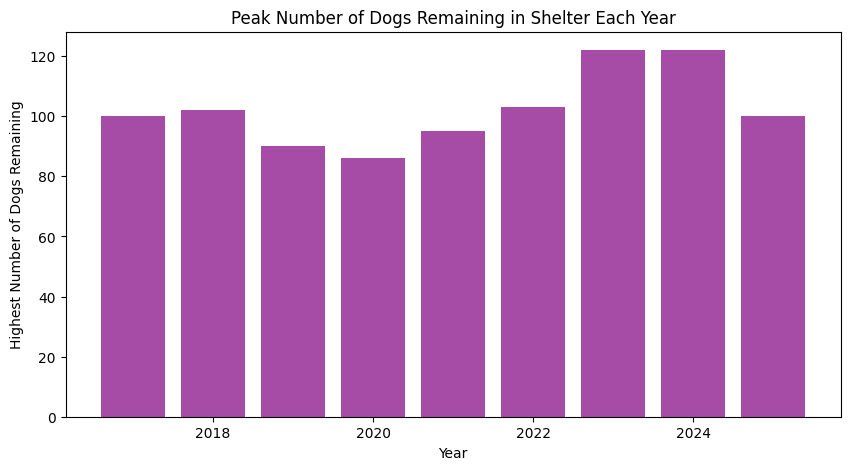

Highest peak was in 2023 with 122 dogs in the shelter.


In [14]:

# Create events for intake and outcome changes
events = pd.concat([
    df_dogs[["Intake Date"]].rename(columns={"Intake Date": "Date"}).assign(Change=1),
    df_dogs[["Outcome Date"]].rename(columns={"Outcome Date": "Date"}).assign(Change=-1)
])

# Remove missing outcome dates (some dogs may still be in shelter)
events = events.dropna().sort_values("Date")

# Calculate cumulative count of dogs in shelter
events["Total Dogs"] = events["Change"].cumsum()

# Find max number of dogs remaining at any time in each year
max_remaining_by_year = events.groupby(events["Date"].dt.year)["Total Dogs"].max()

# Convert to DataFrame
max_remaining_df = max_remaining_by_year.reset_index().rename(columns={"Date": "Year", "Total Dogs": "Max Dogs Remaining"})

# Plot
plt.figure(figsize=(10, 5))
plt.bar(max_remaining_df["Year"], max_remaining_df["Max Dogs Remaining"], color="purple", alpha=0.7)
plt.xlabel("Year")
plt.ylabel("Highest Number of Dogs Remaining")
plt.title("Peak Number of Dogs Remaining in Shelter Each Year")
plt.show()

# Print peak year and count
peak_year = max_remaining_df.loc[max_remaining_df["Max Dogs Remaining"].idxmax()]
print(f"Highest peak was in {peak_year['Year']} with {peak_year['Max Dogs Remaining']} dogs in the shelter.")

Outcome Type
RETURN TO OWNER     2973
ADOPTION            2710
TRANSFER            1995
RESCUE              1558
EUTHANASIA           717
FOSTER TO ADOPT       81
DIED                  62
TRANSPORT             57
HOMEFIRST             47
RETURN TO RESCUE       7
DISPOSAL               7
DUPLICATE              5
MISSING                4
Name: count, dtype: int64


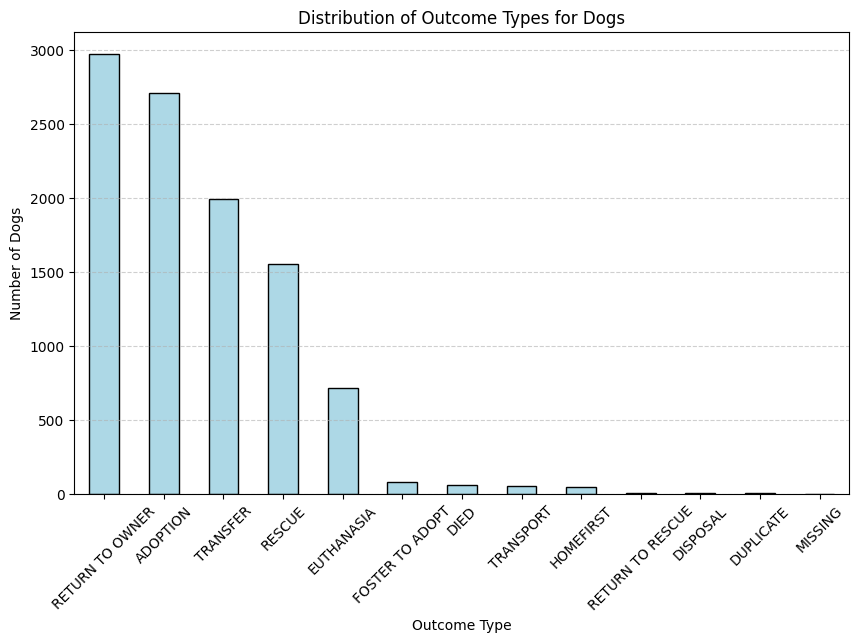

In [15]:
# Replace NaN values in Outcome Type with "Unknown"

# Count occurrences of each outcome type
outcome_counts_dogs = df_dogs["Outcome Type"].value_counts()

# Display results
print(outcome_counts_dogs)

# Plot bar chart including "Unknown" values
plt.figure(figsize=(10, 6))
outcome_counts_dogs.plot(kind='bar', color='lightblue', edgecolor='black')

# Labels and title
plt.xlabel("Outcome Type")
plt.ylabel("Number of Dogs")
plt.title("Distribution of Outcome Types for Dogs")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.show()

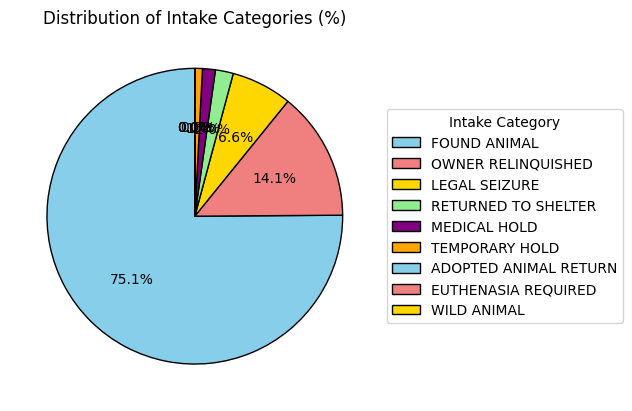

In [16]:
# Plot pie chart **without labels** (names only in the legend)
wedges, texts, autotexts = plt.pie(
    df_dogs["Intake Category"].value_counts(), labels=None, autopct="%1.1f%%",
    colors=["skyblue", "lightcoral", "gold", "lightgreen", "purple", "orange"],
    startangle=90, wedgeprops={"edgecolor": "black"}
)

# Separate legend with intake category names
plt.legend(wedges, df_dogs["Intake Category"].value_counts().index, title="Intake Category", loc="center left", bbox_to_anchor=(1, 0.5))

plt.title("Distribution of Intake Categories (%)")
plt.show()

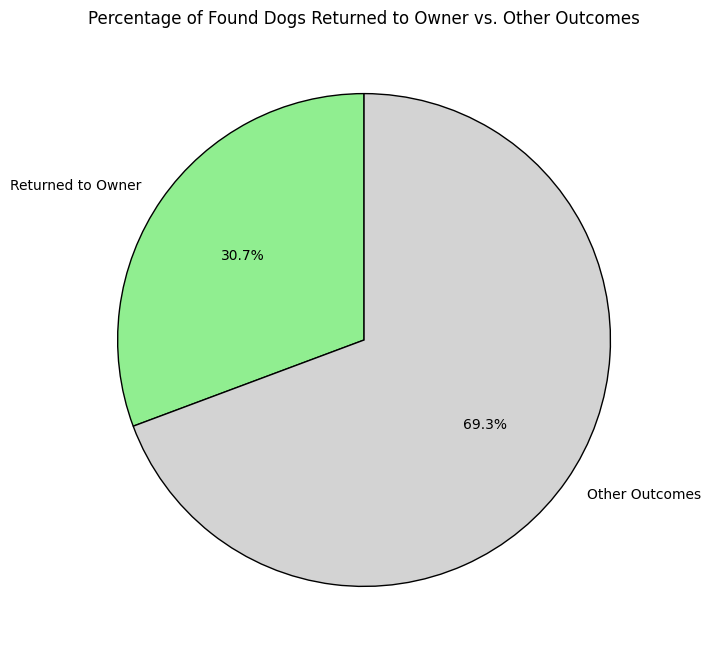

In [17]:
#  Filter only dogs that were categorized as "FOUND ANIMAL"
df_found_dogs = df_dogs[df_dogs["Intake Category"] == "FOUND ANIMAL"].copy()

#  Count outcomes for found dogs
found_dog_outcomes = df_found_dogs["Outcome Type"].value_counts()

#  Separate "RETURN TO OWNER" and group all other outcomes
returned_dogs = found_dog_outcomes.get("RETURN TO OWNER", 0)  # Get count or default to 0
other_outcomes = found_dog_outcomes.sum() - returned_dogs  # Sum all other outcomes

#  Create a new dictionary with two categories
outcome_counts = {"Returned to Owner": returned_dogs, "Other Outcomes": other_outcomes}

#  Create a pie chart
plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    outcome_counts.values(), labels=outcome_counts.keys(), autopct="%1.1f%%",
    colors=["lightgreen", "lightgray"], startangle=90, wedgeprops={"edgecolor": "black"}
)

#  Add title
plt.title("Percentage of Found Dogs Returned to Owner vs. Other Outcomes")

#  Show the chart
plt.show()

<Figure size 1200x600 with 0 Axes>

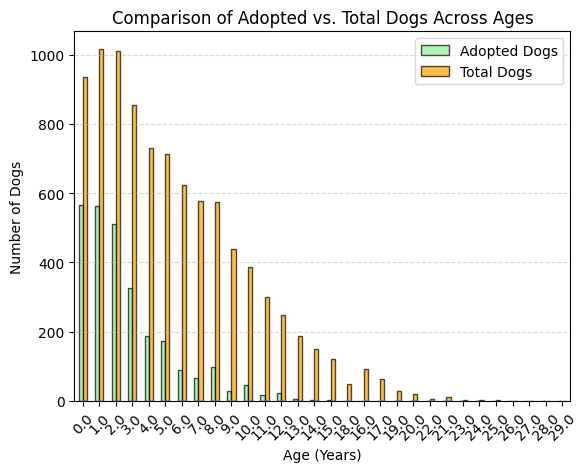

In [18]:
#  Ensure date columns are properly converted to datetime format
df_dogs["DOB"] = pd.to_datetime(df_dogs["DOB"], errors="coerce")
df_dogs["Intake Date"] = pd.to_datetime(df_dogs["Intake Date"], errors="coerce")
df_dogs["Outcome Date"] = pd.to_datetime(df_dogs["Outcome Date"], errors="coerce")

#  Filter dataset to include only adopted dogs
df_adopted = df_dogs[df_dogs["Outcome Type"].str.lower() == "adoption"].copy()

#  Calculate the age of adopted dogs at the time of adoption
df_adopted.loc[:, "Age at Adoption (Years)"] = (
    (df_adopted["Outcome Date"] - df_adopted["DOB"]).dt.total_seconds() / (365.25 * 24 * 3600)
).astype(float).fillna(0).astype(int)  #  Convert to float before casting to int

#  Extract unique years when dogs were adopted
adoption_years = df_adopted["Outcome Date"].dt.year.dropna().unique()

#  Filter the dogs that were **not adopted** but were present during adoption years
df_not_adopted = df_dogs[
    (~df_dogs["Outcome Type"].str.contains("ADOPTION", na=False)) & 
    (df_dogs["Intake Date"].dt.year.isin(adoption_years))
].copy()  #  Ensuring an independent copy to prevent warnings

#  Calculate the age of non-adopted dogs during each adoption year safely
for year in adoption_years:
    df_not_adopted.loc[:, f"Age in {year}"] = year - df_not_adopted["DOB"].dt.year

#  Get the distribution of ages for non-adopted dogs during adoption years
age_distribution_non_adopted = {
    year: df_not_adopted[f"Age in {year}"].value_counts() for year in adoption_years
}

#  Convert dictionary into a DataFrame for non-adopted dogs
df_non_adopted_ages = pd.DataFrame.from_dict(age_distribution_non_adopted, orient="index").T
df_non_adopted_ages.columns = [f"Non-Adopted Age in {year}" for year in df_non_adopted_ages.columns]

#  Create a DataFrame for the ages of adopted dogs
df_adopted_ages = df_adopted["Age at Adoption (Years)"].value_counts().sort_index().rename("Adopted Age Count")

#  Merge both DataFrames for comparison
df_combined = pd.concat([df_adopted_ages, df_non_adopted_ages], axis=1)

#  Filter only ages ≥ 0 (Remove unborn dogs)
df_combined = df_combined[df_combined.index >= 0]

#  Compute averages for visualization
average_adopted_per_age = df_combined["Adopted Age Count"]
average_non_adopted_per_age = df_combined.iloc[:, 1:].mean(axis=1)

#  Create final DataFrame with averages & total counts
df_age_average = pd.DataFrame({
    "Average Adopted Dogs": average_adopted_per_age.fillna(0).astype(int),
    "Average Non-Adopted Dogs": average_non_adopted_per_age.fillna(0).astype(int)
})

#  Add a 'Total' column summing adopted and non-adopted counts
df_age_average["Total Dogs"] = df_age_average.sum(axis=1)

#  Plot the final visualization
plt.figure(figsize=(12, 6))

#  Bar Chart comparing Adopted Dogs vs. Total Dogs across ages
df_age_average[["Average Adopted Dogs", "Total Dogs"]].plot(kind="bar",
    color=["lightgreen", "orange"], edgecolor="black", alpha=0.7)

#  Add labels and title
plt.xlabel("Age (Years)")
plt.ylabel("Number of Dogs")
plt.title("Comparison of Adopted vs. Total Dogs Across Ages")
plt.xticks(rotation=45)
plt.legend(["Adopted Dogs", "Total Dogs"])
plt.grid(axis="y", linestyle="--", alpha=0.5)

#  Display the final chart
plt.show()

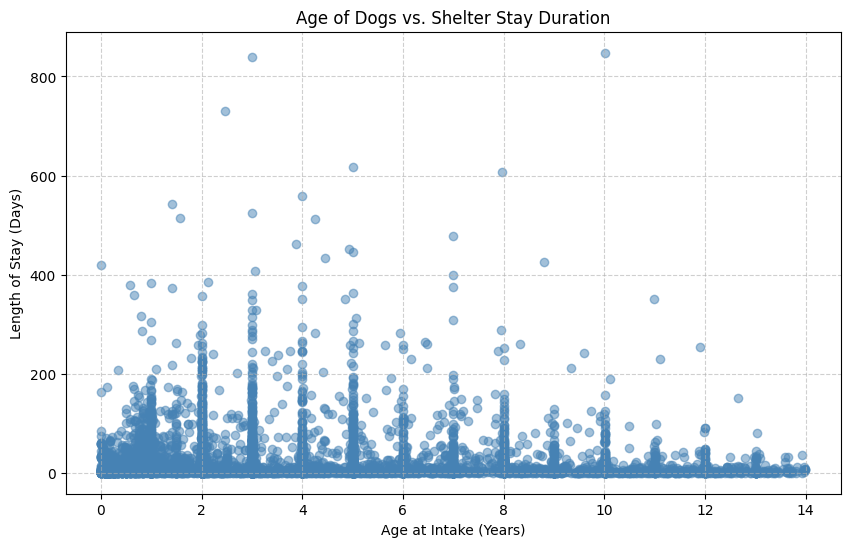

In [20]:

#  Calculate the Length of Stay for each dog
# This is determined by subtracting the intake date from the outcome date, giving the number of days spent in the shelter.
df_dogs["Length of Stay"] = (df_dogs["Outcome Date"] - df_dogs["Intake Date"]).dt.days  

#  Calculate the Age of Dogs at the Time of Intake
# This is found by subtracting the dog's date of birth from its intake date, then converting days into years.
df_dogs["Age at Intake"] = (df_dogs["Intake Date"] - df_dogs["DOB"]).dt.days / 365  

#  Filter dataset to include only dogs aged between 0 and 14 years
# This step removes unrealistic values (negative ages or excessively high ages) to focus on a relevant age range.
df_filtered = df_dogs[(df_dogs["Age at Intake"] >= 0) & (df_dogs["Age at Intake"] <= 14)]  

#  Create a scatter plot to visualize Age at Intake vs. Length of Stay
plt.figure(figsize=(10, 6))  # Set figure size for better readability

#  Scatter plot displaying how age at intake affects shelter stay duration
plt.scatter(df_filtered["Age at Intake"], df_filtered["Length of Stay"], alpha=0.5, color="steelblue")  

#  Add axis labels and title
plt.xlabel("Age at Intake (Years)")  # Label for x-axis (age of dogs upon arrival)
plt.ylabel("Length of Stay (Days)")  # Label for y-axis (number of days spent in shelter)
plt.title("Age of Dogs vs. Shelter Stay Duration")  # Title of the graph

#  Improve readability with a grid
plt.grid(True, linestyle="--", alpha=0.6)  # Add a grid with dashed lines for better visualization

#  Display the final plot
plt.show()

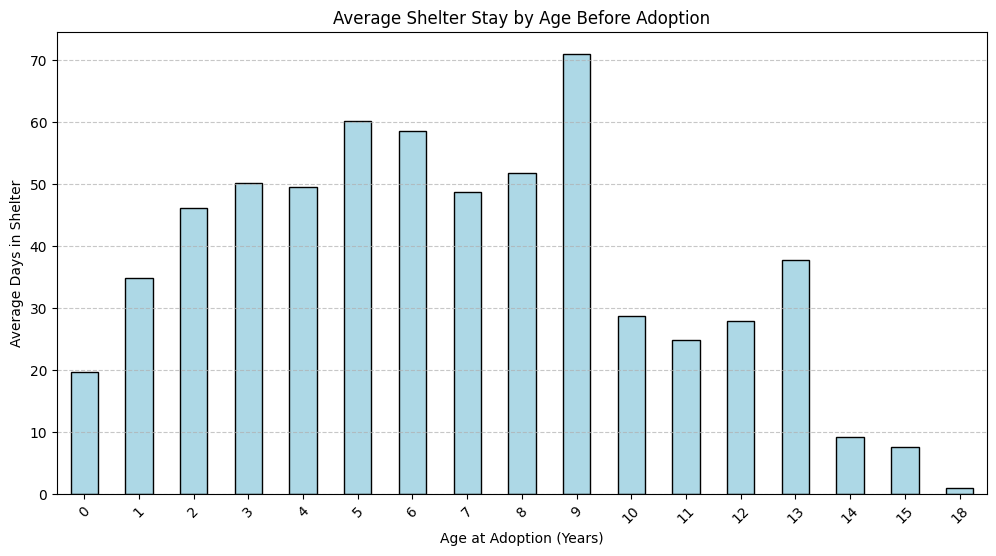

In [21]:
#  Calculate the number of days each adopted dog spent in the shelter
# This is determined by subtracting the intake date from the outcome date.
df_adopted["Days in Shelter"] = (df_adopted["Outcome Date"] - df_adopted["Intake Date"]).dt.days  

#  Group by Age at Adoption and compute the average stay duration
# This calculates the average number of days dogs spent in the shelter before adoption.
average_stay_by_age = df_adopted.groupby("Age at Adoption (Years)")["Days in Shelter"].mean()  

#  Sort by age (from youngest to oldest) instead of sorting by shortest stay duration
# Sorting naturally by age helps to analyze trends across different age groups.
average_stay_by_age_sorted = average_stay_by_age.sort_index()  

#  Create the bar chart to visualize shelter stay duration by age
plt.figure(figsize=(12, 6))  # Set figure size for better readability

#  Bar chart displaying the average shelter stay duration for each age group before adoption
average_stay_by_age_sorted.plot(kind="bar", color="lightblue", edgecolor="black")  

#  Add axis labels and title
plt.xlabel("Age at Adoption (Years)")  # Label for x-axis (age of dogs at adoption)
plt.ylabel("Average Days in Shelter")  # Label for y-axis (number of days spent in shelter)
plt.title("Average Shelter Stay by Age Before Adoption")  # Title of the graph

#  Rotate x-axis labels for better visibility
plt.xticks(rotation=45)  

#  Improve readability with a grid
plt.grid(axis="y", linestyle="--", alpha=0.7)  # Add a horizontal grid for better visualization

#  Display the final plot
plt.show()

In [22]:
print(average_stay_by_age_sorted)

Age at Adoption (Years)
0     19.765018
1     34.843694
2     46.219608
3     50.153846
4     49.576720
5     60.189655
6     58.600000
7     48.696970
8     51.806122
9     70.965517
10    28.782609
11    24.941176
12    27.954545
13    37.857143
14     9.250000
15     7.666667
18     1.000000
Name: Days in Shelter, dtype: float64


Primary Color
BLACK         718
WHITE         509
BROWN         494
TAN           374
GRAY          169
BR BRINDLE     97
BLUE           56
TRICOLOR       56
CREAM          43
RED            42
GOLD           25
FAWN           20
BL BRINDLE     19
BLONDE         17
CHOCOLATE      16
YELLOW         12
SILVER          7
BLUE MERLE      6
BLUE BRIND      5
SEAL            5
BUFF            3
BRN MERLE       3
RED MERLE       2
SABLE           2
UNKNOWN         2
RUDDY           1
BLUE FAWN       1
PINK            1
APRICOT         1
Y BRINDLE       1
DAPPLE          1
CRM TIGER       1
BLK SMOKE       1
Name: count, dtype: int64
Color Combination
BLACK - WHITE            275
WHITE - Not Specified    220
BROWN - Not Specified    190
TAN - Not Specified      183
BLACK - BROWN            154
                        ... 
BLK SMOKE - WHITE          1
SILVER - BLACK             1
SABLE - TAN                1
RED - GOLD                 1
TAN - TRICOLOR             1
Name: count, Length: 118, dty

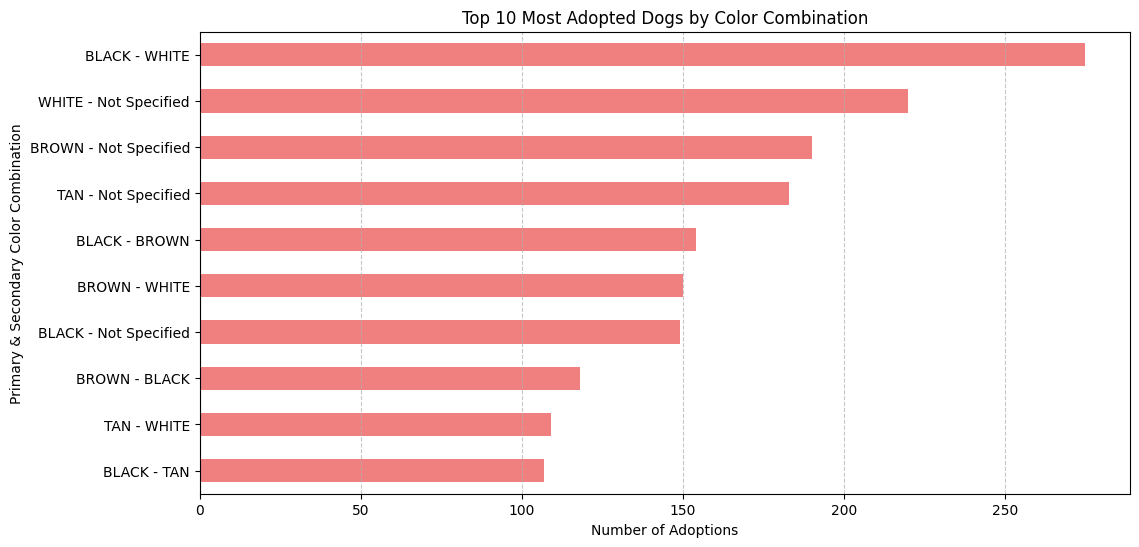

In [46]:

#  Filter dataset to include only adopted dogs
df_adopted = df_dogs[df_dogs["Outcome Type"].str.upper() == "ADOPTION"].copy()  # Use `.copy()` to avoid warning

#  Count the number of adoptions for each primary color
primary_color_adoptions = df_adopted["Primary Color"].value_counts()  

#  Display the adoption count by primary color
print(primary_color_adoptions)  

#  Create a new column for color combinations (Primary + Secondary)
# Using `.loc[]` prevents SettingWithCopyWarning when modifying the DataFrame
df_adopted.loc[:, "Color Combination"] = df_adopted["Primary Color"] + " - " + df_adopted["Secondary Color"].fillna("")  

#  Count the number of adoptions for each color combination
color_combo_adoptions = df_adopted["Color Combination"].value_counts()  

#  Display the adoption count by color combination
print(color_combo_adoptions)  

#  Create a horizontal bar chart for the **Top 10 most adopted color combinations**
plt.figure(figsize=(12, 6))  # Set figure size for clarity
color_combo_adoptions.head(10).sort_values().plot(kind="barh", color="lightcoral")  

#  Add labels, title, and grid for readability
plt.title("Top 10 Most Adopted Dogs by Color Combination")  
plt.xlabel("Number of Adoptions")  
plt.ylabel("Primary & Secondary Color Combination")  
plt.grid(axis="x", linestyle="--", alpha=0.7)  

#  Display the chart
plt.show()

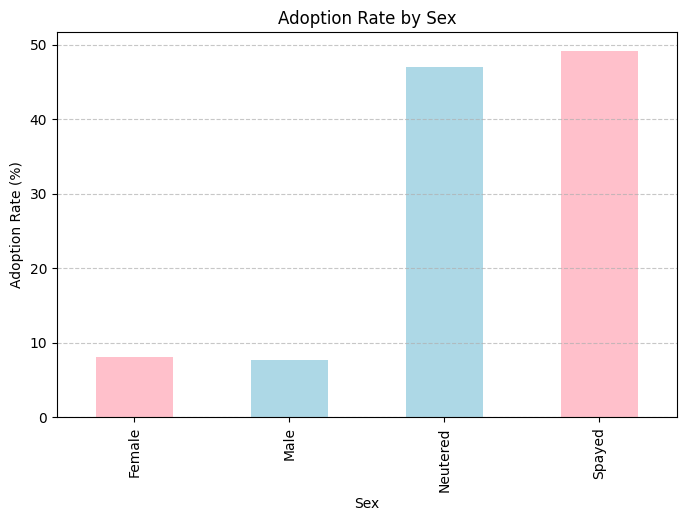

In [47]:
sex_adoption_rate = (df_adopted["Sex"].value_counts() / df_dogs["Sex"].value_counts()) * 100
colors = np.where(sex_adoption_rate.index.isin(["Male", "Neutered"]), "lightblue", "pink")
sex_adoption_rate.dropna().plot(kind="bar", figsize=(8,5), color=colors)
# Ensure Sex values are consistent and clean
sex_adoption_rate.index = sex_adoption_rate.index.str.strip().str.capitalize()

# Explicit color mapping
color_map = {
    "Male": "lightblue",
    "Neutered": "lightblue",
    "Female": "pink",
    "Spayed": "pink"
}

# Apply color mapping
colors = [color_map.get(sex, "gray") for sex in sex_adoption_rate.index]  # Default to gray if unmatched

# Plot with corrected colors
sex_adoption_rate.dropna().plot(kind="bar", figsize=(8,5), color=colors)

# Labels & title
plt.title("Adoption Rate by Sex")
plt.xlabel("Sex")
plt.ylabel("Adoption Rate (%)")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.show()